<a href="https://colab.research.google.com/github/VielF/ColabProjects/blob/main/Pr%C3%A1tica_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidade do Vale do Itajaí<br>
Escola do Mar, Ciência e Tecnologia<br>
Engenharia de Computação - Processamento Digital de Sinais: Imagens<br>
Alunos: Enzo Schork e Vinicius Grisa

# Exercício Avalitivo de Redes Neurais Convolucionais - M3b

##Imports

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Rescaling, RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import zipfile
import os
from google.colab import files
from tensorflow.keras.preprocessing import image


##Preparar arquivos

In [4]:
ZIP_FILE_PATH = '/content/meu_dataset_concreto.zip'
EXTRACT_DIR = '/content/' # Diretório para onde os arquivos serão extraídos

print(f"Extraindo o arquivo '{ZIP_FILE_PATH}'...")
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)
print("Extração concluída!")

Extraindo o arquivo '/content/meu_dataset_concreto.zip'...
Extração concluída!


##Preparar dataset para treino

Found 3500 files belonging to 2 classes.
Found 750 files belonging to 2 classes.
Found 750 files belonging to 2 classes.
Classes encontradas: ['com_rachadura', 'sem_rachadura']

Training samples loaded: 3500
Validation samples loaded: 750
Test samples loaded: 750

Images normalized.

Adding Gaussian noise to the dataset...
Noise added to training, validation, and test sets.


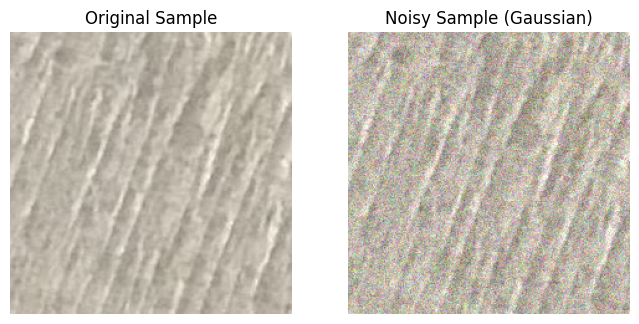

In [5]:
DATA_DIR = os.path.join(EXTRACT_DIR, 'meu_dataset_concreto')

# definições iniciais
IMG_HEIGHT = 227
IMG_WIDTH = 227
BATCH_SIZE = 32


# carrega os dados pós upload
# treino
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, 'train'),
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, 'validation'),
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# teste
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, 'test'),
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes encontradas:", class_names)


# tensorflow -> numpy
def dataset_to_numpy(dataset):
    images = []
    labels = []

    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())

    return np.concatenate(images), np.concatenate(labels)

X_train, y_train = dataset_to_numpy(train_ds)
X_val, y_val = dataset_to_numpy(val_ds)
X_test, y_test = dataset_to_numpy(test_ds)

print(f"\nTraining samples loaded: {len(X_train)}")
print(f"Validation samples loaded: {len(X_val)}")
print(f"Test samples loaded: {len(X_test)}")

# normalizacao
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
print("\nImages normalized.")


# adição de ruído
def add_gaussian_noise(image, mean=0, var=0.01):
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image.astype(np.float32)

print("\nAdding Gaussian noise to the dataset...")
X_train_noisy = np.array([add_gaussian_noise(img) for img in X_train])
X_val_noisy = np.array([add_gaussian_noise(img) for img in X_val])
X_test_noisy = np.array([add_gaussian_noise(img) for img in X_test])
print("Noise added to training, validation, and test sets.")

# amostra
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Sample")
plt.imshow(X_train[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Noisy Sample (Gaussian)")
plt.imshow(X_train_noisy[0])
plt.axis('off')
plt.show()

##Aplicar filtragem pré processamento

Applying pre-processing flow to datasets...


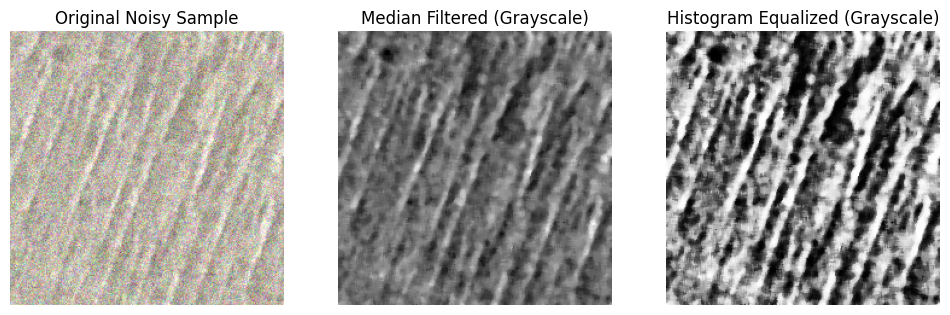

In [6]:
def apply_image_processing_flow(images_array):
    processed_images = []
    for img in images_array:
        img_uint8 = (img * 255).astype(np.uint8)

        # aplicar grayscale
        if len(img_uint8.shape) == 3 and img_uint8.shape[2] == 3:
            img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_uint8

        # filtro de mediana
        filtered_img_gray = cv2.medianBlur(img_gray, 5) # 5x5 kernel

        # equalização de histograma
        equalized_img_gray = cv2.equalizeHist(filtered_img_gray)

        processed_images.append(equalized_img_gray)

    processed_images = np.array(processed_images)
    if len(processed_images.shape) == 3:
        processed_images = np.expand_dims(processed_images, axis=-1)

    return processed_images.astype('float32') / 255.0

print("Applying pre-processing flow to datasets...")
X_train_processed = apply_image_processing_flow(X_train_noisy)
X_val_processed = apply_image_processing_flow(X_val_noisy)
X_test_processed = apply_image_processing_flow(X_test_noisy)

# com ruído
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Noisy Sample")
plt.imshow(X_train_noisy[0])
plt.axis('off')

# resultado intermediário
plt.subplot(1, 3, 2)
plt.title("Median Filtered (Grayscale)")
temp_img_uint8 = (X_train_noisy[0] * 255).astype(np.uint8)
if len(temp_img_uint8.shape) == 3 and temp_img_uint8.shape[2] == 3:
    temp_img_gray = cv2.cvtColor(temp_img_uint8, cv2.COLOR_RGB2GRAY)
else:
    temp_img_gray = temp_img_uint8
temp_filtered = cv2.medianBlur(temp_img_gray, 5)
plt.imshow(temp_filtered, cmap='gray')
plt.axis('off')

# equalizada
plt.subplot(1, 3, 3)
plt.title("Histogram Equalized (Grayscale)")
plt.imshow(X_train_processed[0].squeeze(), cmap='gray')
plt.axis('off')
plt.show()

##Treinar o modelo apresentando resultados

Input shape for CNN: (227, 227, 1)
Number of classes: 2

--- Initial CNN Model Architecture ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 225, 225, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 53, 53, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,058 (394.76 KB)

 Trainable params: 101,058 (394.76 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Initial CNN Model ---
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.6077 - loss: 0.6354 - val_accuracy: 0.8280 - val_loss: 0.4308 - learning_rate: 0.0010
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8585 - loss: 0.3435 - val_accuracy: 0.9067 - val_loss: 0.2127 - learning_rate: 0.0010
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9240 - loss: 0.2178 - val_accuracy: 0.9400 - val_loss: 0.1525 - learning_rate: 0.0010
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9483 - loss: 0.1369 - val_accuracy: 0.9720 - val_loss: 0.0801 - learning_rate: 0.0010
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9685 - loss: 0.0940 - val_accuracy: 0.9813 - val_loss: 0.0607 - learning_rate: 0.0010
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9685 - loss: 0.1022 - val_accuracy: 0.9787 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44


--- Evaluating Initial CNN Model on Test Set ---
24/24 - 0s - 13ms/step - accuracy: 0.9880 - loss: 0.0442
Test Loss: 0.0442
Test Accuracy: 0.9880


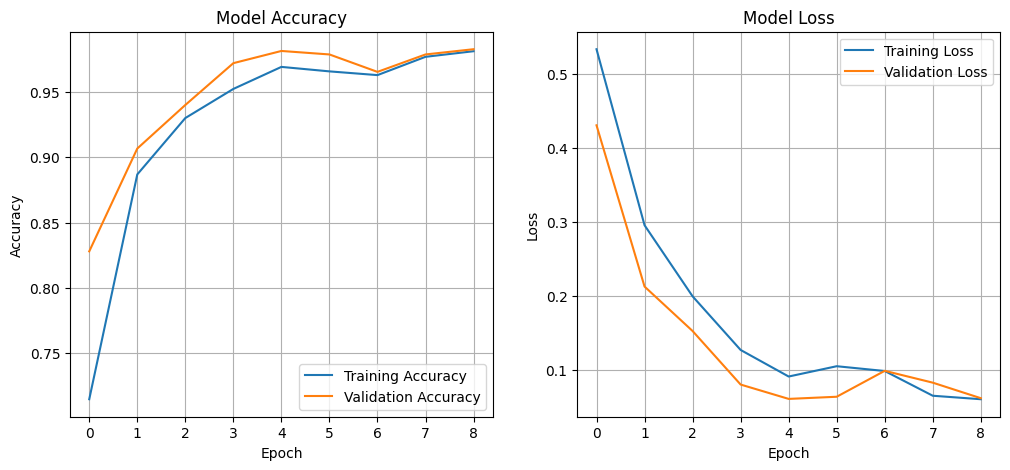

In [13]:
input_shape = X_train_processed.shape[1:]
num_classes = 2

print(f"Input shape for CNN: {input_shape}")
print(f"Number of classes: {num_classes}")

# definir modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),  # substitui flatten
    Dense(64, activation='relu'),  # reduzido de 128 para 64
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Initial CNN Model Architecture ---")
model.summary()

# callbacks para evitar overfitting e ajustar lr
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# treinar modelo
print("\n--- Training Initial CNN Model ---")
history = model.fit(
    X_train_processed, y_train,
    epochs=30, # aumentar épocas
    validation_data=(X_val_processed, y_val),
    batch_size=32,
    callbacks=callbacks
)

# salvar modelo
model.save('modelo_rachaduras_final.h5')

# resultados
print("\n--- Evaluating Initial CNN Model on Test Set ---")
loss_improved, accuracy_improved = model.evaluate(X_test_processed, y_test, verbose=2)
print(f"Test Loss: {loss_improved:.4f}")
print(f"Test Accuracy: {accuracy_improved:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

##Teste em imagem do dataset de teste:

Carregando modelo treinado do arquivo...
Modelo carregado com sucesso.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


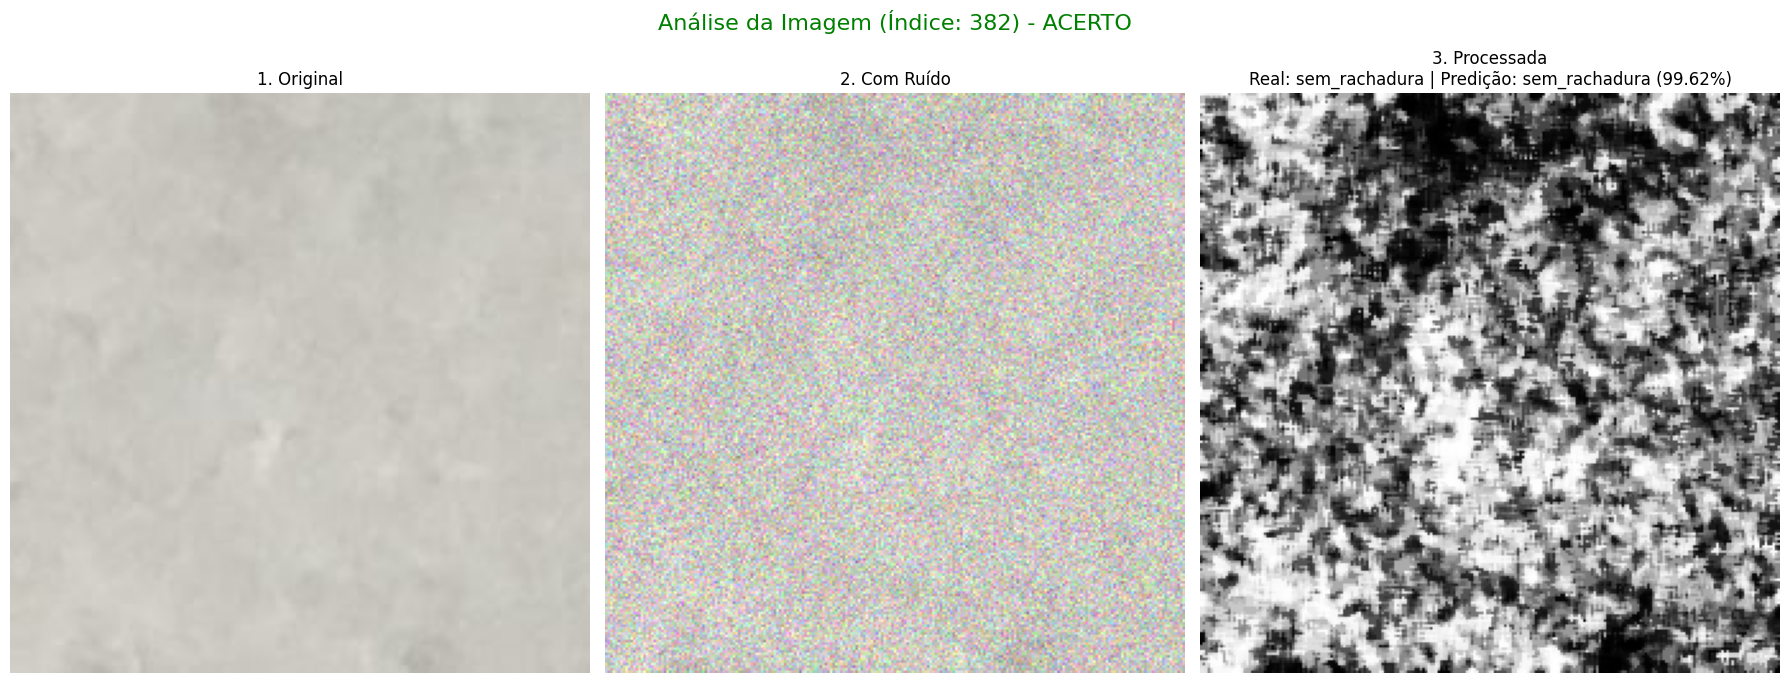

In [14]:
print("Carregando modelo treinado do arquivo...")
loaded_model = load_model('modelo_rachaduras_final.h5')
print("Modelo carregado com sucesso.")

# seleciona imagem aleatoria do dataset de teste
random_index = np.random.randint(0, len(X_test))

# pré processamento
original_image = X_test[random_index]
noisy_image = X_test_noisy[random_index]
processed_image = X_test_processed[random_index]
true_label_index = y_test[random_index]
true_label_name = class_names[true_label_index]

image_for_prediction = np.expand_dims(processed_image, axis=0)


# predição
prediction = loaded_model.predict(image_for_prediction) # <-- Usando o 'loaded_model'
predicted_label_index = np.argmax(prediction[0])
predicted_label_name = class_names[predicted_label_index]
confidence = np.max(prediction[0])

# resultado
fig = plt.figure(figsize=(18, 7))
if predicted_label_name == true_label_name:
    result_color = 'green'
    result_text = 'ACERTO'
else:
    result_color = 'red'
    result_text = 'ERRO'

fig.suptitle(f'Análise da Imagem (Índice: {random_index}) - {result_text}', fontsize=16, color=result_color)
plt.subplot(1, 3, 1); plt.imshow(original_image); plt.title("1. Original"); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(noisy_image); plt.title("2. Com Ruído"); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(processed_image.squeeze(), cmap='gray'); plt.title(f"3. Processada\nReal: {true_label_name} | Predição: {predicted_label_name} ({confidence:.2%})"); plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##Teste em novo upload de imagem fora do dataset de teste:


Por favor, faça o upload de uma nova imagem para classificação.


Saving 10282_1.jpg to 10282_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


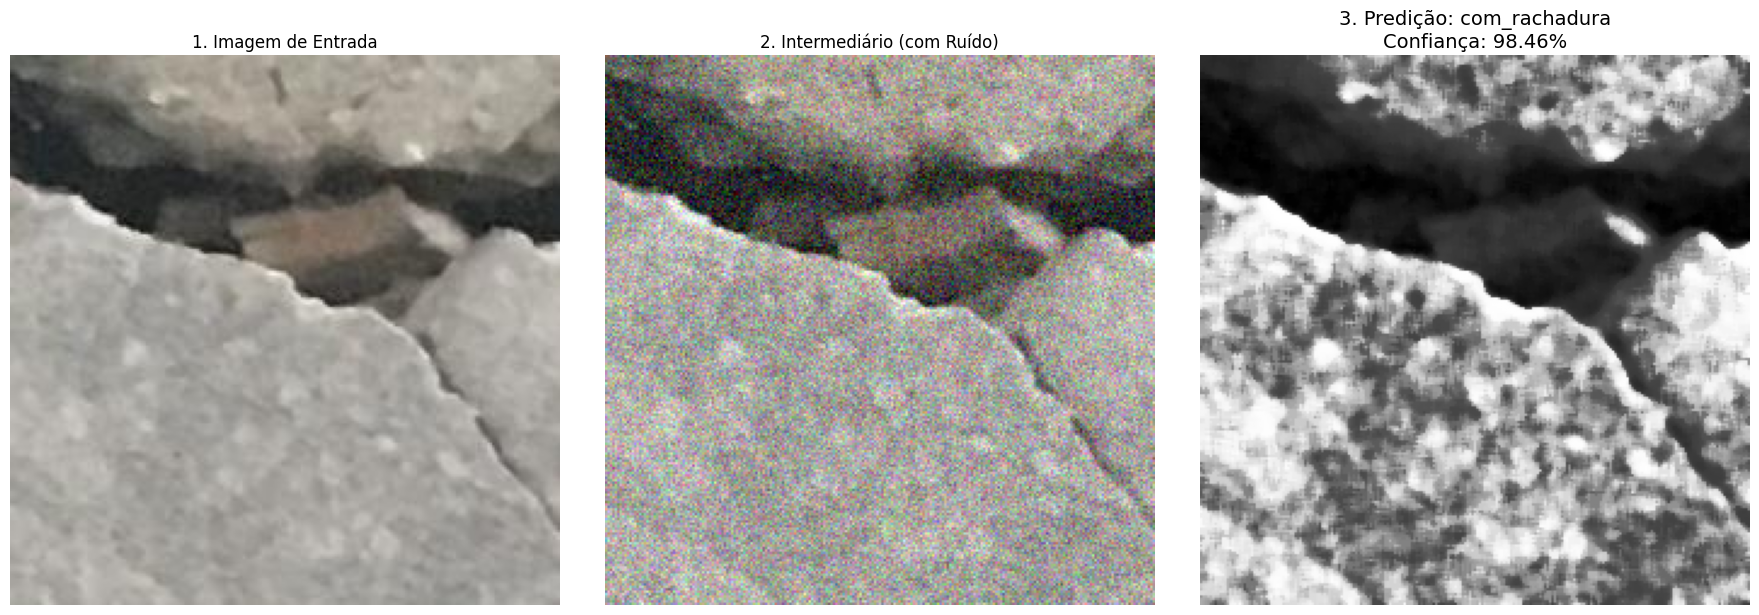

In [15]:
print("\nPor favor, faça o upload de uma nova imagem para classificação.")
uploaded = files.upload()

file_path = list(uploaded.keys())[0]

# pré processamento
img_original = image.load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img_original)
img_normalized = img_array / 255.0

img_noisy = add_gaussian_noise(img_normalized)

img_noisy_batch = np.expand_dims(img_noisy, axis=0)
img_final_processed = apply_image_processing_flow(img_noisy_batch)

# predição
prediction = loaded_model.predict(img_final_processed)
predicted_label_index = np.argmax(prediction[0])
predicted_label_name = class_names[predicted_label_index]
confidence = np.max(prediction[0])

# resultado
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_original)
plt.title("1. Imagem de Entrada")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_noisy)
plt.title("2. Intermediário (com Ruído)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_final_processed.squeeze(), cmap='gray')
plt.title(f"3. Predição: {predicted_label_name}\nConfiança: {confidence:.2%}", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()